In [1]:
from tqdm import tqdm
import requests
import pandas as pd
import numpy as np

from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem import Draw
from rdkit.Chem.Draw import SimilarityMaps
from rdkit import Chem, DataStructs

import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Flatten, MaxPool1D

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

/home/milosevicn/.local/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
2023-01-29 16:38:57.407613: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
models = dict()
cols = dict()

for model in ["ke1", "ke2", "ke3"]:
    models[model] = keras.models.load_model(f"models/skeec/nn_{model}.h5")
    cols[model] = [f"{model}_na", f"{model}_dn", f"{model}_up"]

2023-01-29 16:38:59.482043: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-01-29 16:38:59.482898: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-01-29 16:38:59.926638: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-29 16:38:59.926897: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2070 SUPER computeCapability: 7.5
coreClock: 1.815GHz coreCount: 40 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2023-01-29 16:38:59.926938: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-01-29 16:38:59.931328: I tensorflow/stream_executor/platf

In [3]:
test_data = [
    "data_tests/Chemical List EDSP21LIST2-2021-12-28.csv",
    "data_tests/Chemical List EDSPUOC-2022-06-16.csv",
    "data_tests/Chemical List OSHA-2021-12-28.csv",
    "data_tests/Chemical List UBAPMT-2021-12-28.csv",
    "data_tests/Chemical List EDSP21LIST1-2021-12-28.csv"    
]

In [19]:
def inference(row):
    try:
        smiles = str(row["smiles"])
        mol = Chem.MolFromSmiles(smiles)
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2) # TODO: can replace morgan with other fingerprint!
        arr = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(fp, arr)
        
        for model in ["ke1", "ke2", "ke3"]:
            # conv:
            arr = arr.reshape(-1, 2048, 1)
            out = list(models[model].predict(arr).round()[0])
            # fc:
            # out = list(models[model].predict(arr.reshape(1, -1)).round()[0])
            
            #print(out)
            
            #print(tf.nn.softmax(out))
            
            clazz = np.argmax(tf.nn.softmax(out))
            
            out = [0, 0, 0]
            out[clazz] = 1
            
            # print(out)
            
            for i, col in enumerate(cols[model]):
                row[col] = int(out[i])
        
    except Exception as e:
        # print(e)
        print("Bad smiles string? For:", row["PREFERRED NAME"])
        
    return row

In [20]:
for test in test_data:    
    df = pd.read_csv(test)
    for col_list in cols.values():
        for col in col_list:
            df[col] = "unknown"

    df = df.apply(lambda x: inference(x), axis=1)
    
    df.to_csv(test.replace("data_tests/", "inference_results/skeec/"), index=False)

Bad smiles string? For: Polychlorinated biphenyls


RDKit ERROR: [18:59:32] SMILES Parse Error: syntax error while parsing: ['Rgp'][N+]1(CC)CCOCC1.CCOS(=O)(=O)[O-]
[18:59:32] SMILES Parse Error: syntax error while parsing: ['Rgp'][N+]1(CC)CCOCC1.CCOS(=O)(=O)[O-]
RDKit ERROR: [18:59:32] SMILES Parse Error: Failed parsing SMILES '['Rgp'][N+]1(CC)CCOCC1.CCOS(=O)(=O)[O-]' for input: '['Rgp'][N+]1(CC)CCOCC1.CCOS(=O)(=O)[O-]'
[18:59:32] SMILES Parse Error: Failed parsing SMILES '['Rgp'][N+]1(CC)CCOCC1.CCOS(=O)(=O)[O-]' for input: '['Rgp'][N+]1(CC)CCOCC1.CCOS(=O)(=O)[O-]'


Bad smiles string? For: Onium compounds, morpholinium, 4-ethyl-4-soya alkyl, Et sulfates


RDKit ERROR: [18:59:41] SMILES Parse Error: syntax error while parsing: [X]C(C)C.c1ccc(cc1)c2ccccc2
[18:59:41] SMILES Parse Error: syntax error while parsing: [X]C(C)C.c1ccc(cc1)c2ccccc2
RDKit ERROR: [18:59:41] SMILES Parse Error: Failed parsing SMILES '[X]C(C)C.c1ccc(cc1)c2ccccc2' for input: '[X]C(C)C.c1ccc(cc1)c2ccccc2'
[18:59:41] SMILES Parse Error: Failed parsing SMILES '[X]C(C)C.c1ccc(cc1)c2ccccc2' for input: '[X]C(C)C.c1ccc(cc1)c2ccccc2'


Bad smiles string? For: Isopropylbiphenyl


RDKit ERROR: [18:59:45] SMILES Parse Error: syntax error while parsing: [Cl-].['Rgp'][N+](C)(C)Cc1ccccc1
[18:59:45] SMILES Parse Error: syntax error while parsing: [Cl-].['Rgp'][N+](C)(C)Cc1ccccc1
RDKit ERROR: [18:59:45] SMILES Parse Error: Failed parsing SMILES '[Cl-].['Rgp'][N+](C)(C)Cc1ccccc1' for input: '[Cl-].['Rgp'][N+](C)(C)Cc1ccccc1'
[18:59:45] SMILES Parse Error: Failed parsing SMILES '[Cl-].['Rgp'][N+](C)(C)Cc1ccccc1' for input: '[Cl-].['Rgp'][N+](C)(C)Cc1ccccc1'


Bad smiles string? For: Benzalkonium chloride


RDKit ERROR: [19:00:16] SMILES Parse Error: syntax error while parsing: [X]N.[X]N.Cc1ccccc1
[19:00:16] SMILES Parse Error: syntax error while parsing: [X]N.[X]N.Cc1ccccc1
RDKit ERROR: [19:00:16] SMILES Parse Error: Failed parsing SMILES '[X]N.[X]N.Cc1ccccc1' for input: '[X]N.[X]N.Cc1ccccc1'
[19:00:16] SMILES Parse Error: Failed parsing SMILES '[X]N.[X]N.Cc1ccccc1' for input: '[X]N.[X]N.Cc1ccccc1'


Bad smiles string? For: Toluenediamine


RDKit ERROR: [19:00:26] SMILES Parse Error: syntax error while parsing: [X]C(C)C.[X]C(C)C.c1ccc2ccccc2c1
[19:00:26] SMILES Parse Error: syntax error while parsing: [X]C(C)C.[X]C(C)C.c1ccc2ccccc2c1
RDKit ERROR: [19:00:26] SMILES Parse Error: Failed parsing SMILES '[X]C(C)C.[X]C(C)C.c1ccc2ccccc2c1' for input: '[X]C(C)C.[X]C(C)C.c1ccc2ccccc2c1'
[19:00:26] SMILES Parse Error: Failed parsing SMILES '[X]C(C)C.[X]C(C)C.c1ccc2ccccc2c1' for input: '[X]C(C)C.[X]C(C)C.c1ccc2ccccc2c1'


Bad smiles string? For: Diisopropylnaphthalene


RDKit ERROR: [19:00:30] SMILES Parse Error: syntax error while parsing: [X]OS(=O)(=O)O.N(c1ccccc1)c2ccc(cc2)C(=C3C=CC(=Nc4ccccc4)C=C3)c5ccc(Nc6ccccc6)cc5
[19:00:30] SMILES Parse Error: syntax error while parsing: [X]OS(=O)(=O)O.N(c1ccccc1)c2ccc(cc2)C(=C3C=CC(=Nc4ccccc4)C=C3)c5ccc(Nc6ccccc6)cc5
RDKit ERROR: [19:00:30] SMILES Parse Error: Failed parsing SMILES '[X]OS(=O)(=O)O.N(c1ccccc1)c2ccc(cc2)C(=C3C=CC(=Nc4ccccc4)C=C3)c5ccc(Nc6ccccc6)cc5' for input: '[X]OS(=O)(=O)O.N(c1ccccc1)c2ccc(cc2)C(=C3C=CC(=Nc4ccccc4)C=C3)c5ccc(Nc6ccccc6)cc5'
[19:00:30] SMILES Parse Error: Failed parsing SMILES '[X]OS(=O)(=O)O.N(c1ccccc1)c2ccc(cc2)C(=C3C=CC(=Nc4ccccc4)C=C3)c5ccc(Nc6ccccc6)cc5' for input: '[X]OS(=O)(=O)O.N(c1ccccc1)c2ccc(cc2)C(=C3C=CC(=Nc4ccccc4)C=C3)c5ccc(Nc6ccccc6)cc5'


Bad smiles string? For: C.I. Pigment Blue 61
Bad smiles string? For: 2-Ethylhexenal


RDKit WARNING: [19:00:43] WARNING: not removing hydrogen atom without neighbors
[19:00:43] WARNING: not removing hydrogen atom without neighbors
RDKit ERROR: [19:00:50] Explicit valence for atom # 3 Si, 8, is greater than permitted
[19:00:50] Explicit valence for atom # 3 Si, 8, is greater than permitted


Bad smiles string? For: Sodium hexafluorosilicate


RDKit WARNING: [19:00:52] WARNING: not removing hydrogen atom without neighbors
[19:00:52] WARNING: not removing hydrogen atom without neighbors
RDKit ERROR: [19:01:12] Explicit valence for atom # 1 B, 7, is greater than permitted
[19:01:12] Explicit valence for atom # 1 B, 7, is greater than permitted


Bad smiles string? For: Boron sodium hydride (BNaH4)


RDKit ERROR: [19:01:16] SMILES Parse Error: syntax error while parsing: ['Rgp'][N+](C)(C)[O-]
[19:01:16] SMILES Parse Error: syntax error while parsing: ['Rgp'][N+](C)(C)[O-]
RDKit ERROR: [19:01:16] SMILES Parse Error: Failed parsing SMILES '['Rgp'][N+](C)(C)[O-]' for input: '['Rgp'][N+](C)(C)[O-]'
[19:01:16] SMILES Parse Error: Failed parsing SMILES '['Rgp'][N+](C)(C)[O-]' for input: '['Rgp'][N+](C)(C)[O-]'


Bad smiles string? For: C10-16-alkyldimethyl amine N-oxides


RDKit ERROR: [19:01:21] SMILES Parse Error: syntax error while parsing: ['Rgp']C(=O)OCC(COP(=O)([O-])OCC[N+](C)(C)C)OC(=O)['Rgp']
[19:01:21] SMILES Parse Error: syntax error while parsing: ['Rgp']C(=O)OCC(COP(=O)([O-])OCC[N+](C)(C)C)OC(=O)['Rgp']
RDKit ERROR: [19:01:21] SMILES Parse Error: Failed parsing SMILES '['Rgp']C(=O)OCC(COP(=O)([O-])OCC[N+](C)(C)C)OC(=O)['Rgp']' for input: '['Rgp']C(=O)OCC(COP(=O)([O-])OCC[N+](C)(C)C)OC(=O)['Rgp']'
[19:01:21] SMILES Parse Error: Failed parsing SMILES '['Rgp']C(=O)OCC(COP(=O)([O-])OCC[N+](C)(C)C)OC(=O)['Rgp']' for input: '['Rgp']C(=O)OCC(COP(=O)([O-])OCC[N+](C)(C)C)OC(=O)['Rgp']'


Bad smiles string? For: Lecithin


RDKit ERROR: [19:01:24] SMILES Parse Error: syntax error while parsing: [X]C.C(Oc1ccccc1)C2CO2
[19:01:24] SMILES Parse Error: syntax error while parsing: [X]C.C(Oc1ccccc1)C2CO2
RDKit ERROR: [19:01:24] SMILES Parse Error: Failed parsing SMILES '[X]C.C(Oc1ccccc1)C2CO2' for input: '[X]C.C(Oc1ccccc1)C2CO2'
[19:01:24] SMILES Parse Error: Failed parsing SMILES '[X]C.C(Oc1ccccc1)C2CO2' for input: '[X]C.C(Oc1ccccc1)C2CO2'


Bad smiles string? For: 2-[(Methylphenoxy)methyl]oxirane


RDKit ERROR: [19:01:26] SMILES Parse Error: syntax error while parsing: [X]C(C)C.[X]C(C)C.c1ccc(cc1)c2ccccc2
[19:01:26] SMILES Parse Error: syntax error while parsing: [X]C(C)C.[X]C(C)C.c1ccc(cc1)c2ccccc2
RDKit ERROR: [19:01:26] SMILES Parse Error: Failed parsing SMILES '[X]C(C)C.[X]C(C)C.c1ccc(cc1)c2ccccc2' for input: '[X]C(C)C.[X]C(C)C.c1ccc(cc1)c2ccccc2'
[19:01:26] SMILES Parse Error: Failed parsing SMILES '[X]C(C)C.[X]C(C)C.c1ccc(cc1)c2ccccc2' for input: '[X]C(C)C.[X]C(C)C.c1ccc(cc1)c2ccccc2'


Bad smiles string? For: ar,ar'-Bis(1-methylethyl)-1,1'-biphenyl
Bad smiles string? For: Polychlorinated biphenyls


RDKit ERROR: [19:01:48] Explicit valence for atom # 0 O, 3, is greater than permitted
[19:01:48] Explicit valence for atom # 0 O, 3, is greater than permitted


Bad smiles string? For: Zinc pyrithione
Bad smiles string? For: Bis[omega-hydrogenpoly(oxyethylene)]oleylamine


RDKit ERROR: [19:01:52] SMILES Parse Error: syntax error while parsing: ['Rgp']c1ccc(O)cc1
[19:01:52] SMILES Parse Error: syntax error while parsing: ['Rgp']c1ccc(O)cc1
RDKit ERROR: [19:01:52] SMILES Parse Error: Failed parsing SMILES '['Rgp']c1ccc(O)cc1' for input: '['Rgp']c1ccc(O)cc1'
[19:01:52] SMILES Parse Error: Failed parsing SMILES '['Rgp']c1ccc(O)cc1' for input: '['Rgp']c1ccc(O)cc1'


Bad smiles string? For: 4-Nonylphenol, branched


RDKit ERROR: [19:01:53] Explicit valence for atom # 3 Sn, 8, is greater than permitted
[19:01:53] Explicit valence for atom # 3 Sn, 8, is greater than permitted


Bad smiles string? For: Disodium stannate


RDKit ERROR: [19:01:57] SMILES Parse Error: syntax error while parsing: ['Rgp']NCCCN
[19:01:57] SMILES Parse Error: syntax error while parsing: ['Rgp']NCCCN
RDKit ERROR: [19:01:57] SMILES Parse Error: Failed parsing SMILES '['Rgp']NCCCN' for input: '['Rgp']NCCCN'
[19:01:57] SMILES Parse Error: Failed parsing SMILES '['Rgp']NCCCN' for input: '['Rgp']NCCCN'


Bad smiles string? For: Amines, N-coco alkyltrimethylenedi-
Bad smiles string? For: 1,3-Dimethylbenzene, benzylated


RDKit ERROR: [19:02:04] SMILES Parse Error: syntax error while parsing: [Cl-].[Cl-].[Cl-].[X]C.[X]C.[X]CCCCCCCCCCCC.[X]CCCCCCCCCCCC.[X]C[N+](C)(C)C.C[N+](C)(C)Cc1ccccc1.C[N+](C)(C)Cc2ccccc2
[19:02:04] SMILES Parse Error: syntax error while parsing: [Cl-].[Cl-].[Cl-].[X]C.[X]C.[X]CCCCCCCCCCCC.[X]CCCCCCCCCCCC.[X]C[N+](C)(C)C.C[N+](C)(C)Cc1ccccc1.C[N+](C)(C)Cc2ccccc2
RDKit ERROR: [19:02:04] SMILES Parse Error: Failed parsing SMILES '[Cl-].[Cl-].[Cl-].[X]C.[X]C.[X]CCCCCCCCCCCC.[X]CCCCCCCCCCCC.[X]C[N+](C)(C)C.C[N+](C)(C)Cc1ccccc1.C[N+](C)(C)Cc2ccccc2' for input: '[Cl-].[Cl-].[Cl-].[X]C.[X]C.[X]CCCCCCCCCCCC.[X]CCCCCCCCCCCC.[X]C[N+](C)(C)C.C[N+](C)(C)Cc1ccccc1.C[N+](C)(C)Cc2ccccc2'
[19:02:04] SMILES Parse Error: Failed parsing SMILES '[Cl-].[Cl-].[Cl-].[X]C.[X]C.[X]CCCCCCCCCCCC.[X]CCCCCCCCCCCC.[X]C[N+](C)(C)C.C[N+](C)(C)Cc1ccccc1.C[N+](C)(C)Cc2ccccc2' for input: '[Cl-].[Cl-].[Cl-].[X]C.[X]C.[X]CCCCCCCCCCCC.[X]CCCCCCCCCCCC.[X]C[N+](C)(C)C.C[N+](C)(C)Cc1ccccc1.C[N+](C)(C)Cc2ccccc2'


Bad smiles string? For: Quaternium-11


RDKit ERROR: [19:02:16] SMILES Parse Error: syntax error while parsing: [X]O.CCCCCCCCCCC
[19:02:16] SMILES Parse Error: syntax error while parsing: [X]O.CCCCCCCCCCC
RDKit ERROR: [19:02:16] SMILES Parse Error: Failed parsing SMILES '[X]O.CCCCCCCCCCC' for input: '[X]O.CCCCCCCCCCC'
[19:02:16] SMILES Parse Error: Failed parsing SMILES '[X]O.CCCCCCCCCCC' for input: '[X]O.CCCCCCCCCCC'


Bad smiles string? For: Undecanol


RDKit WARNING: [19:02:23] WARNING: not removing hydrogen atom without neighbors
[19:02:23] WARNING: not removing hydrogen atom without neighbors
RDKit ERROR: [19:02:23] Explicit valence for atom # 10 O, 3, is greater than permitted
[19:02:23] Explicit valence for atom # 10 O, 3, is greater than permitted


Bad smiles string? For: C.I.Acid Green 35


RDKit ERROR: [19:02:36] Explicit valence for atom # 6 B, 5, is greater than permitted
[19:02:36] Explicit valence for atom # 6 B, 5, is greater than permitted


Bad smiles string? For: Sodium perborate tetrahydrate


RDKit ERROR: [19:02:52] SMILES Parse Error: syntax error while parsing: CC(C)(c1ccc(OCC2CO2)cc1)c3ccc(OCC4CO4)cc3.[XH]
[19:02:52] SMILES Parse Error: syntax error while parsing: CC(C)(c1ccc(OCC2CO2)cc1)c3ccc(OCC4CO4)cc3.[XH]
RDKit ERROR: [19:02:52] SMILES Parse Error: Failed parsing SMILES 'CC(C)(c1ccc(OCC2CO2)cc1)c3ccc(OCC4CO4)cc3.[XH]' for input: 'CC(C)(c1ccc(OCC2CO2)cc1)c3ccc(OCC4CO4)cc3.[XH]'
[19:02:52] SMILES Parse Error: Failed parsing SMILES 'CC(C)(c1ccc(OCC2CO2)cc1)c3ccc(OCC4CO4)cc3.[XH]' for input: 'CC(C)(c1ccc(OCC2CO2)cc1)c3ccc(OCC4CO4)cc3.[XH]'


Bad smiles string? For: Epoxy resin


RDKit ERROR: [19:02:55] Explicit valence for atom # 6 O, 3, is greater than permitted
[19:02:55] Explicit valence for atom # 6 O, 3, is greater than permitted


Bad smiles string? For: Cobaltate(1-), [2,4-dihydro-4-[(2-hydroxy-5-nitrophenyl)azo]-5-methyl-2-phenyl-3H-pyrazol-3-onato(2-)][1-[(2-hydroxy-5-nitrophenyl)azo]-2-naphthalenolato(2-)]-, sodium


RDKit ERROR: [19:03:19] SMILES Parse Error: syntax error while parsing: [X]O.CCCCCCCCCCCCC
[19:03:19] SMILES Parse Error: syntax error while parsing: [X]O.CCCCCCCCCCCCC
RDKit ERROR: [19:03:19] SMILES Parse Error: Failed parsing SMILES '[X]O.CCCCCCCCCCCCC' for input: '[X]O.CCCCCCCCCCCCC'
[19:03:19] SMILES Parse Error: Failed parsing SMILES '[X]O.CCCCCCCCCCCCC' for input: '[X]O.CCCCCCCCCCCCC'


Bad smiles string? For: Tridecanol


RDKit ERROR: [19:03:30] SMILES Parse Error: syntax error while parsing: [X]C.[X]C.SP(=S)(Oc1ccccc1)Oc2ccccc2
[19:03:30] SMILES Parse Error: syntax error while parsing: [X]C.[X]C.SP(=S)(Oc1ccccc1)Oc2ccccc2
RDKit ERROR: [19:03:30] SMILES Parse Error: Failed parsing SMILES '[X]C.[X]C.SP(=S)(Oc1ccccc1)Oc2ccccc2' for input: '[X]C.[X]C.SP(=S)(Oc1ccccc1)Oc2ccccc2'
[19:03:30] SMILES Parse Error: Failed parsing SMILES '[X]C.[X]C.SP(=S)(Oc1ccccc1)Oc2ccccc2' for input: '[X]C.[X]C.SP(=S)(Oc1ccccc1)Oc2ccccc2'


Bad smiles string? For: O,O-Ditolyl phosphorodithioate


RDKit ERROR: [19:03:44] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
[19:03:44] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5

RDKit ERROR: 


Bad smiles string? For: Ferrocene


RDKit ERROR: [19:04:00] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[19:04:00] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7

RDKit ERROR: 


Bad smiles string? For: Titanocene dichloride


RDKit ERROR: [19:04:13] SMILES Parse Error: syntax error while parsing: [X]C.[X]C.CCCCCCCOC(=O)CCCCC(=O)OCCCCCCC
[19:04:13] SMILES Parse Error: syntax error while parsing: [X]C.[X]C.CCCCCCCOC(=O)CCCCC(=O)OCCCCCCC
RDKit ERROR: [19:04:13] SMILES Parse Error: Failed parsing SMILES '[X]C.[X]C.CCCCCCCOC(=O)CCCCC(=O)OCCCCCCC' for input: '[X]C.[X]C.CCCCCCCOC(=O)CCCCC(=O)OCCCCCCC'
[19:04:13] SMILES Parse Error: Failed parsing SMILES '[X]C.[X]C.CCCCCCCOC(=O)CCCCC(=O)OCCCCCCC' for input: '[X]C.[X]C.CCCCCCCOC(=O)CCCCC(=O)OCCCCCCC'


Bad smiles string? For: Diisooctyl adipate


RDKit ERROR: [19:04:13] Explicit valence for atom # 2 O, 3, is greater than permitted
[19:04:13] Explicit valence for atom # 2 O, 3, is greater than permitted


Bad smiles string? For: (Diethyl ether)trifluoroborane


RDKit ERROR: [19:04:17] SMILES Parse Error: syntax error while parsing: [X]CCCCCCCCCCCC.OS(=O)(=O)c1ccccc1
[19:04:17] SMILES Parse Error: syntax error while parsing: [X]CCCCCCCCCCCC.OS(=O)(=O)c1ccccc1
RDKit ERROR: [19:04:17] SMILES Parse Error: Failed parsing SMILES '[X]CCCCCCCCCCCC.OS(=O)(=O)c1ccccc1' for input: '[X]CCCCCCCCCCCC.OS(=O)(=O)c1ccccc1'
[19:04:17] SMILES Parse Error: Failed parsing SMILES '[X]CCCCCCCCCCCC.OS(=O)(=O)c1ccccc1' for input: '[X]CCCCCCCCCCCC.OS(=O)(=O)c1ccccc1'


Bad smiles string? For: Potassium dodecylbenzenesulfonate


RDKit ERROR: [19:04:35] SMILES Parse Error: syntax error while parsing: [Na+].['Rgp']N(C)CCS(=O)(=O)[O-]
[19:04:35] SMILES Parse Error: syntax error while parsing: [Na+].['Rgp']N(C)CCS(=O)(=O)[O-]
RDKit ERROR: [19:04:35] SMILES Parse Error: Failed parsing SMILES '[Na+].['Rgp']N(C)CCS(=O)(=O)[O-]' for input: '[Na+].['Rgp']N(C)CCS(=O)(=O)[O-]'
[19:04:35] SMILES Parse Error: Failed parsing SMILES '[Na+].['Rgp']N(C)CCS(=O)(=O)[O-]' for input: '[Na+].['Rgp']N(C)CCS(=O)(=O)[O-]'


Bad smiles string? For: Ethanesulfonic acid, 2-(methylamino)-, N-tall-oil fatty acyl derivs., sodium salts


RDKit WARNING: [19:04:47] WARNING: not removing hydrogen atom without neighbors
[19:04:47] WARNING: not removing hydrogen atom without neighbors


Bad smiles string? For: Diethoxylated methyl glucopyranoside 2,6-dioleate


RDKit ERROR: [19:04:55] SMILES Parse Error: syntax error while parsing: [X]C(C)CCCCCC.[X][N+](=O)[O-].C\C=C\C(=O)Oc1ccccc1[N+](=O)[O-]
[19:04:55] SMILES Parse Error: syntax error while parsing: [X]C(C)CCCCCC.[X][N+](=O)[O-].C\C=C\C(=O)Oc1ccccc1[N+](=O)[O-]
RDKit ERROR: [19:04:55] SMILES Parse Error: Failed parsing SMILES '[X]C(C)CCCCCC.[X][N+](=O)[O-].C\C=C\C(=O)Oc1ccccc1[N+](=O)[O-]' for input: '[X]C(C)CCCCCC.[X][N+](=O)[O-].C\C=C\C(=O)Oc1ccccc1[N+](=O)[O-]'
[19:04:55] SMILES Parse Error: Failed parsing SMILES '[X]C(C)CCCCCC.[X][N+](=O)[O-].C\C=C\C(=O)Oc1ccccc1[N+](=O)[O-]' for input: '[X]C(C)CCCCCC.[X][N+](=O)[O-].C\C=C\C(=O)Oc1ccccc1[N+](=O)[O-]'


Bad smiles string? For: Dinocap


RDKit ERROR: [19:05:00] SMILES Parse Error: syntax error while parsing: [X]F.FC(F)C(F)Cl
[19:05:00] SMILES Parse Error: syntax error while parsing: [X]F.FC(F)C(F)Cl
RDKit ERROR: [19:05:00] SMILES Parse Error: Failed parsing SMILES '[X]F.FC(F)C(F)Cl' for input: '[X]F.FC(F)C(F)Cl'
[19:05:00] SMILES Parse Error: Failed parsing SMILES '[X]F.FC(F)C(F)Cl' for input: '[X]F.FC(F)C(F)Cl'


Bad smiles string? For: Chlorotetrafluoroethane


RDKit ERROR: [19:05:05] SMILES Parse Error: syntax error while parsing: [X]C.CCCCCCCO
[19:05:05] SMILES Parse Error: syntax error while parsing: [X]C.CCCCCCCO
RDKit ERROR: [19:05:05] SMILES Parse Error: Failed parsing SMILES '[X]C.CCCCCCCO' for input: '[X]C.CCCCCCCO'
[19:05:05] SMILES Parse Error: Failed parsing SMILES '[X]C.CCCCCCCO' for input: '[X]C.CCCCCCCO'


Bad smiles string? For: Isooctanol


RDKit ERROR: [19:05:06] SMILES Parse Error: syntax error while parsing: [Ca+2].[X]CCCCCCCCCCCC.[X]CCCCCCCCCCCC.[O-]S(=O)(=O)c1ccccc1.[O-]S(=O)(=O)c2ccccc2
[19:05:06] SMILES Parse Error: syntax error while parsing: [Ca+2].[X]CCCCCCCCCCCC.[X]CCCCCCCCCCCC.[O-]S(=O)(=O)c1ccccc1.[O-]S(=O)(=O)c2ccccc2
RDKit ERROR: [19:05:06] SMILES Parse Error: Failed parsing SMILES '[Ca+2].[X]CCCCCCCCCCCC.[X]CCCCCCCCCCCC.[O-]S(=O)(=O)c1ccccc1.[O-]S(=O)(=O)c2ccccc2' for input: '[Ca+2].[X]CCCCCCCCCCCC.[X]CCCCCCCCCCCC.[O-]S(=O)(=O)c1ccccc1.[O-]S(=O)(=O)c2ccccc2'
[19:05:06] SMILES Parse Error: Failed parsing SMILES '[Ca+2].[X]CCCCCCCCCCCC.[X]CCCCCCCCCCCC.[O-]S(=O)(=O)c1ccccc1.[O-]S(=O)(=O)c2ccccc2' for input: '[Ca+2].[X]CCCCCCCCCCCC.[X]CCCCCCCCCCCC.[O-]S(=O)(=O)c1ccccc1.[O-]S(=O)(=O)c2ccccc2'


Bad smiles string? For: Calcium dodecylbenzene sulfonate


RDKit WARNING: [19:05:35] WARNING: not removing hydrogen atom without neighbors
[19:05:35] WARNING: not removing hydrogen atom without neighbors
RDKit ERROR: [19:05:36] Explicit valence for atom # 3 F, 2, is greater than permitted
[19:05:36] Explicit valence for atom # 3 F, 2, is greater than permitted


Bad smiles string? For: Cryolite
Bad smiles string? For: Pentene
Bad smiles string? For: Sodium bis[2,4-dihydro-4-[(2-hydroxy-5-nitrophenyl)azo]-5-methyl-2-phenyl-3H-pyrazol-3-onato(2-)]cobaltate(1-)


RDKit ERROR: [19:07:38] Explicit valence for atom # 9 N, 4, is greater than permitted
[19:07:38] Explicit valence for atom # 9 N, 4, is greater than permitted


Bad smiles string? For: Copper phthalocyanine


RDKit ERROR: [19:07:42] Explicit valence for atom # 6 O, 3, is greater than permitted
[19:07:42] Explicit valence for atom # 6 O, 3, is greater than permitted


Bad smiles string? For: C.I. Acid Red 186


RDKit ERROR: [19:08:00] SMILES Parse Error: syntax error while parsing: [X]C.CCCCCCCO
[19:08:00] SMILES Parse Error: syntax error while parsing: [X]C.CCCCCCCO
RDKit ERROR: [19:08:00] SMILES Parse Error: Failed parsing SMILES '[X]C.CCCCCCCO' for input: '[X]C.CCCCCCCO'
[19:08:00] SMILES Parse Error: Failed parsing SMILES '[X]C.CCCCCCCO' for input: '[X]C.CCCCCCCO'


Bad smiles string? For: Isooctanol


RDKit WARNING: [19:08:03] WARNING: not removing hydrogen atom without neighbors
[19:08:03] WARNING: not removing hydrogen atom without neighbors
RDKit ERROR: [19:08:04] SMILES Parse Error: syntax error while parsing: [X][N+](=O)[O-].[O-][N+](=O)c1ccccc1
[19:08:04] SMILES Parse Error: syntax error while parsing: [X][N+](=O)[O-].[O-][N+](=O)c1ccccc1
RDKit ERROR: [19:08:04] SMILES Parse Error: Failed parsing SMILES '[X][N+](=O)[O-].[O-][N+](=O)c1ccccc1' for input: '[X][N+](=O)[O-].[O-][N+](=O)c1ccccc1'
[19:08:04] SMILES Parse Error: Failed parsing SMILES '[X][N+](=O)[O-].[O-][N+](=O)c1ccccc1' for input: '[X][N+](=O)[O-].[O-][N+](=O)c1ccccc1'


Bad smiles string? For: Dinitrobenzene (all isomers)


RDKit ERROR: [19:08:05] Explicit valence for atom # 0 B, 4, is greater than permitted
[19:08:05] Explicit valence for atom # 0 B, 4, is greater than permitted


Bad smiles string? For: Diborane


RDKit ERROR: [19:08:08] SMILES Parse Error: syntax error while parsing: [X][N+](=O)[O-].[X][N+](=O)[O-].Cc1ccccc1
[19:08:08] SMILES Parse Error: syntax error while parsing: [X][N+](=O)[O-].[X][N+](=O)[O-].Cc1ccccc1
RDKit ERROR: [19:08:08] SMILES Parse Error: Failed parsing SMILES '[X][N+](=O)[O-].[X][N+](=O)[O-].Cc1ccccc1' for input: '[X][N+](=O)[O-].[X][N+](=O)[O-].Cc1ccccc1'
[19:08:08] SMILES Parse Error: Failed parsing SMILES '[X][N+](=O)[O-].[X][N+](=O)[O-].Cc1ccccc1' for input: '[X][N+](=O)[O-].[X][N+](=O)[O-].Cc1ccccc1'


Bad smiles string? For: Dinitrotoluene


RDKit WARNING: [19:08:36] WARNING: not removing hydrogen atom without neighbors
[19:08:36] WARNING: not removing hydrogen atom without neighbors
RDKit ERROR: [19:08:41] Explicit valence for atom # 4 C, 5, is greater than permitted
[19:08:41] Explicit valence for atom # 4 C, 5, is greater than permitted


Bad smiles string? For: (Methylcyclopentadienyl)tricarbonylmanganese


RDKit ERROR: [19:08:51] SMILES Parse Error: syntax error while parsing: [X]N.[X]N.Cc1ccccc1
[19:08:51] SMILES Parse Error: syntax error while parsing: [X]N.[X]N.Cc1ccccc1
RDKit ERROR: [19:08:51] SMILES Parse Error: Failed parsing SMILES '[X]N.[X]N.Cc1ccccc1' for input: '[X]N.[X]N.Cc1ccccc1'
[19:08:51] SMILES Parse Error: Failed parsing SMILES '[X]N.[X]N.Cc1ccccc1' for input: '[X]N.[X]N.Cc1ccccc1'


Bad smiles string? For: Toluenediamine


RDKit ERROR: [19:08:54] SMILES Parse Error: syntax error while parsing: [X][N+](=O)[O-].[X][N+](=O)[O-].Cc1ccccc1
[19:08:54] SMILES Parse Error: syntax error while parsing: [X][N+](=O)[O-].[X][N+](=O)[O-].Cc1ccccc1
RDKit ERROR: [19:08:54] SMILES Parse Error: Failed parsing SMILES '[X][N+](=O)[O-].[X][N+](=O)[O-].Cc1ccccc1' for input: '[X][N+](=O)[O-].[X][N+](=O)[O-].Cc1ccccc1'
[19:08:54] SMILES Parse Error: Failed parsing SMILES '[X][N+](=O)[O-].[X][N+](=O)[O-].Cc1ccccc1' for input: '[X][N+](=O)[O-].[X][N+](=O)[O-].Cc1ccccc1'


Bad smiles string? For: Dinitrotoluene


RDKit ERROR: [19:09:03] Explicit valence for atom # 4 C, 5, is greater than permitted
[19:09:03] Explicit valence for atom # 4 C, 5, is greater than permitted


Bad smiles string? For: (Methylcyclopentadienyl)tricarbonylmanganese


RDKit ERROR: [19:09:04] SMILES Parse Error: syntax error while parsing: [X]C(C)C.CC(C)c1ccccc1
[19:09:04] SMILES Parse Error: syntax error while parsing: [X]C(C)C.CC(C)c1ccccc1
RDKit ERROR: [19:09:04] SMILES Parse Error: Failed parsing SMILES '[X]C(C)C.CC(C)c1ccccc1' for input: '[X]C(C)C.CC(C)c1ccccc1'
[19:09:04] SMILES Parse Error: Failed parsing SMILES '[X]C(C)C.CC(C)c1ccccc1' for input: '[X]C(C)C.CC(C)c1ccccc1'


Bad smiles string? For: Diisopropylbenzene


In [4]:
dfs = []

for f in test_data:
    df = pd.read_csv(f.replace("data_tests/", "inference_results/skeec/"))
    df["Database"] = f.split("/")[-1].replace(".csv", "").replace("Chemical List ", "")
    df["Use category"] = ""
    df = df[["casrn", "PREFERRED NAME", "Database", "Use category", "ke1_na", "ke1_dn", "ke1_up", "ke2_na", "ke2_dn", "ke2_up", "ke3_na", "ke3_dn", "ke3_up", "# ToxCast Active"]]
    
    def process(df, ke_name):
        df[ke_name] = ""
        df[ke_name] = np.where(df[f"{ke_name}_na"].astype("string") == "1", "NA", df[ke_name])    
        df[ke_name] = np.where(df[f"{ke_name}_up"].astype("string") == "1", "Up", df[ke_name])
        df[ke_name] = np.where(df[f"{ke_name}_dn"].astype("string") == "1", "Down", df[ke_name])    
        df[ke_name] = np.where(df[f"{ke_name}_dn"].astype("string") == "unknown", "Unknown", df[ke_name])
        del df[f"{ke_name}_na"], df[f"{ke_name}_dn"], df[f"{ke_name}_up"]

    process(df, "ke1")
    process(df, "ke2")
    process(df, "ke3")
    
        
    dfs.append(df)

In [5]:
dfs[4]

,casrn,PREFERRED NAME,Database,Use category,# ToxCast Active,ke1,ke2,ke3
0,1861-40-1,Benfluralin,EDSP21LIST1-2021-12-28,,90/965,NA,Down,NA
1,950-37-8,Methidathion,EDSP21LIST1-2021-12-28,,90/990,Up,NA,Down
2,298-04-4,Disulfoton,EDSP21LIST1-2021-12-28,,85/981,NA,NA,NA
3,117-81-7,Di(2-ethylhexyl) phthalate,EDSP21LIST1-2021-12-28,,103/1150,Up,Down,NA
4,90-43-7,2-Phenylphenol,EDSP21LIST1-2021-12-28,,77/990,NA,Down,NA
...,...,...,...,...,...,...,...,...
62,84-66-2,Diethyl phthalate,EDSP21LIST1-2021-12-28,,11/880,NA,NA,Up
63,108-88-3,Toluene,EDSP21LIST1-2021-12-28,,0/235,NA,NA,NA
64,1071-83-6,Glyphosate,EDSP21LIST1-2021-12-28,,0/52,NA,NA,NA
65,67-64-1,Acetone,EDSP21LIST1-2021-12-28,,1/235,NA,NA,NA


In [6]:
pd.concat(dfs).to_csv("inference_results/skeec_single_table.csv", index=False)

In [7]:
df = pd.read_csv("inference_results/skeec_single_table.csv", converters = {'ke1': str, 'ke2': str, 'ke3': str})
df

,casrn,PREFERRED NAME,Database,Use category,# ToxCast Active,ke1,ke2,ke3
0,1336-36-3,Polychlorinated biphenyls,EDSP21LIST2-2021-12-28,NaN,,Unknown,Unknown,Unknown
1,77182-82-2,Glufosinate-ammonium,EDSP21LIST2-2021-12-28,NaN,,NA,NA,NA
2,55-63-0,Trinitroglycerin,EDSP21LIST2-2021-12-28,NaN,,NA,NA,NA
3,14797-73-0,Perchlorate,EDSP21LIST2-2021-12-28,NaN,,NA,NA,NA
4,121-82-4,Cyclonite,EDSP21LIST2-2021-12-28,NaN,,NA,NA,NA
...,...,...,...,...,...,...,...,...
9713,84-66-2,Diethyl phthalate,EDSP21LIST1-2021-12-28,NaN,11/880,NA,NA,Up
9714,108-88-3,Toluene,EDSP21LIST1-2021-12-28,NaN,0/235,NA,NA,NA
9715,1071-83-6,Glyphosate,EDSP21LIST1-2021-12-28,NaN,0/52,NA,NA,NA
9716,67-64-1,Acetone,EDSP21LIST1-2021-12-28,NaN,1/235,NA,NA,NA


In [8]:
df = df.drop_duplicates(subset=['casrn'])

In [9]:
df[["ke1", "ke2", "ke3"]].value_counts()

ke1      ke2      ke3    
NA       NA       NA         6180
         Down     NA          731
Up       NA       NA          514
Down     Down     NA          321
Up       Down     NA          287
Down     NA       NA          285
NA       NA       Down         63
                  Up           54
Unknown  Unknown  Unknown      52
NA       Down     Down         43
Down     Down     Down         21
Up       NA       Up           17
NA       Down     Up           13
Up       Down     Up           11
                  Down         10
Down     NA       Up            7
Up       NA       Down          7
Down     Down     Up            7
NA       Up       NA            4
Down     NA       Down          2
dtype: int64

In [10]:
# Up       Down      Down izvuci
udd = df[(df["ke1"] == "Up") & (df["ke2"] == "Down") & (df["ke3"] == "Down")]

udd.to_csv("inference_results/skeec_udd.csv", index=False)

udd

,casrn,PREFERRED NAME,Database,Use category,# ToxCast Active,ke1,ke2,ke3
90,68694-11-1,Triflumizole,EDSP21LIST2-2021-12-28,NaN,418/1156,Up,Down,Down
147,35554-44-0,Imazalil,EDSPUOC-2022-06-16,NaN,406/1189,Up,Down,Down
2666,25646-71-3,"Methanesulfonamide, N-[2-[(4-amino-3-methylphe...",EDSPUOC-2022-06-16,NaN,,Up,Down,Down
4459,120983-64-4,2-(1-Chlorocyclopropyl)-1-(2-chlorophenyl)-3-(...,EDSPUOC-2022-06-16,NaN,52/513,Up,Down,Down
4603,122453-73-0,4-Bromo-2-(4-chlorophenyl)-1-(ethoxymethyl)-5-...,EDSPUOC-2022-06-16,NaN,196/460,Up,Down,Down
5273,85509-19-9,Flusilazole,EDSPUOC-2022-06-16,NaN,316/1066,Up,Down,Down
6248,480-40-0,Chrysin,EDSPUOC-2022-06-16,NaN,144/532,Up,Down,Down
6315,5397-34-2,"2,4'-Dihydroxydiphenyl sulfone",EDSPUOC-2022-06-16,NaN,,Up,Down,Down
7254,127-27-5,alpha-Pimaricacid,EDSPUOC-2022-06-16,NaN,,Up,Down,Down
7959,24169-02-6,Econazole nitrate,EDSPUOC-2022-06-16,NaN,189/446,Up,Down,Down


In [8]:
skeec_udd = pd.read_csv("inference_results/skeec_udd.csv")
skeec_udd["Type"] = "skec"
sac_udd = pd.read_csv("inference_results/sac_udd.csv")
sac_udd["Type"] = "sac"

joined = pd.concat([skeec_udd, sac_udd])

joined["PREFERRED NAME"].value_counts().to_csv("inference_results/presek.csv")

In [9]:
df[["ke1"]].value_counts(), df[["ke2"]].value_counts(), df[["ke3"]].value_counts()

(ke1    
 NA         8015
 Up          921
 Down        722
 Unknown      60
 dtype: int64,
 ke2    
 NA         8044
 Down       1608
 Unknown      60
 Up            6
 dtype: int64,
 ke3    
 NA         9355
 Down        164
 Up          139
 Unknown      60
 dtype: int64)

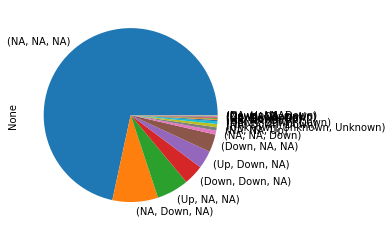

In [11]:
df[["ke1", "ke2", "ke3"]].value_counts().plot(kind="pie")

In [13]:
counts = df[(df["ke1"] != "Unknown") | (df["ke2"] != "Unknown") | (df["ke3"] != "Unknown")][["ke1", "ke2", "ke3"]].value_counts()

In [14]:
counts = pd.DataFrame(counts)

In [15]:
counts["test"] = counts.index

In [16]:
def process(row):
    
    t = 3 - row["test"].count("NA")
    row["involved"] = t
    
    return row

counts = counts.apply(process, axis=1)

In [17]:
counts

0                test  involved
ke1  ke2  ke3                                     
NA   NA   NA    6180        (NA, NA, NA)         0
     Down NA     731      (NA, Down, NA)         1
Up   NA   NA     514        (Up, NA, NA)         1
Down Down NA     321    (Down, Down, NA)         2
Up   Down NA     287      (Up, Down, NA)         2
Down NA   NA     285      (Down, NA, NA)         1
NA   NA   Down    63      (NA, NA, Down)         1
          Up      54        (NA, NA, Up)         1
     Down Down    43    (NA, Down, Down)         2
Down Down Down    21  (Down, Down, Down)         3
Up   NA   Up      17        (Up, NA, Up)         2
NA   Down Up      13      (NA, Down, Up)         2
Up   Down Up      11      (Up, Down, Up)         3
          Down    10    (Up, Down, Down)         3
Down NA   Up       7      (Down, NA, Up)         2
Up   NA   Down     7      (Up, NA, Down)         2
Down Down Up       7    (Down, Down, Up)         3
NA   Up   NA       4        (NA, Up, NA)         1
Down NA   Down     2    (Down, NA, Down)         2

,Key Event Involvement,invol
involved,,
0,6180,0
1,1651,1
2,697,2
3,49,3


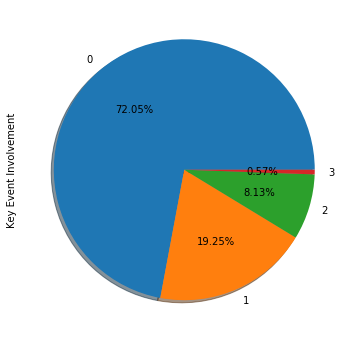

In [20]:
counts = counts.groupby("involved").sum("0")
counts["invol"] = counts.index
counts.columns = ["Key Event Involvement", "invol"]
counts.plot(kind="pie", x="invol", y="Key Event Involvement", legend=False, 
                   autopct='%1.2f%%', explode=(0, 0, 0, 0), 
                   shadow=True, startangle=0, figsize=(10,6))
counts

In [19]:
counts

,counts,invol
involved,,
0,6986,0
1,1839,1
2,778,2
3,55,3


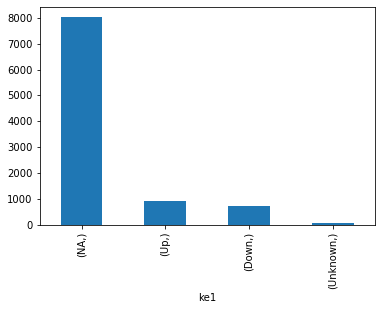

In [73]:
df[["ke1"]].value_counts().plot(kind="bar")

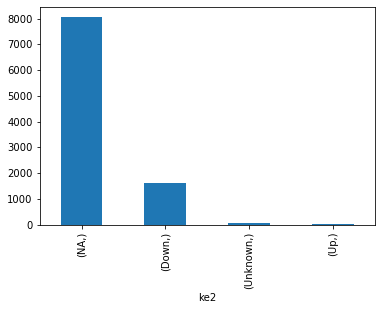

In [74]:
df[["ke2"]].value_counts().plot(kind="bar")

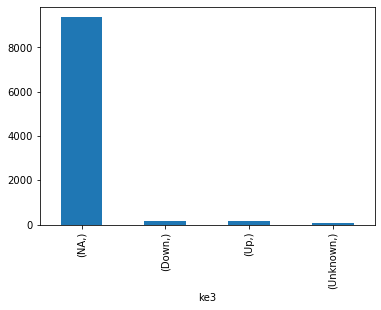

In [75]:
df[["ke3"]].value_counts().plot(kind="bar")

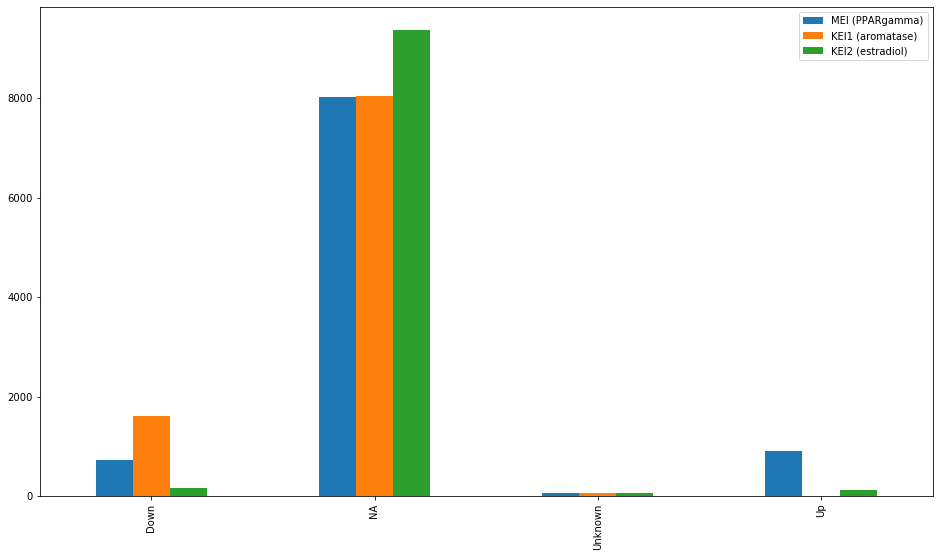

In [99]:
pd.DataFrame({"MEI (PPARgamma)": df["ke1"].value_counts(), "KEI1 (aromatase)": df["ke2"].value_counts(), "KEI2 (estradiol)": df["ke3"].value_counts()}).plot(kind="bar", figsize=(16, 9))